In [1]:
%matplotlib inline

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import scipy.stats as st

from statsmodels.graphics.mosaicplot import mosaic

In [3]:
RANDOM_STATE = 26
INPUT_DATA = "data/ai4i2020.csv"
META_DATA = "data/machine_meta_data.xlsx"

# Predictive Maintenance Draft

## Data

### Description

The first data set contains data from a parts-machining process. It is one of the few suitable datasets on the topic that I have managed to find. The data is not measured from an actual process, it was artificially generated using a set of rules. Here are the [description](https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset), [paper](https://ieeexplore.ieee.org/document/9253083), and [data](https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv).

### Meta data

Meta data (e.g. columns descriptions) is prepared and stored in an external excel file.

In [4]:
machine_meta = pd.read_excel(META_DATA, sheet_name = "features")

### Columns

The original columns are read from the excel meta data file. A `group` column is used for easier filtering later. Full description of the variables and how they are generated is in the data description (see link above).

In [5]:
original_columns = machine_meta[["original_name", "group", "description_short"]]
original_columns

,original_name,group,description_short
0,UDI,na,observation identifier
1,Product ID,product,product numberc (type + unique serial number)
2,Type,product,"product type (H, M, L)"
3,Air temperature [K],process,ambient air temperature in K
4,Process temperature [K],process,process temperature in K
5,Rotational speed [rpm],process,motor speed in rpm
6,Torque [Nm],process,motor torque in Nm
7,Tool wear [min],process,accumulated machining tool wear in min
8,Machine failure,failure,flag that any of the 5 failures has occurred
9,TWF,failure,tool wear failure


## Clean and tidy

### Read

In [6]:
machine = pd.read_csv(INPUT_DATA)

In [7]:
machine.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

### Get to know

In [8]:
machine.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

In [9]:
machine.shape

(10000, 14)

In [10]:
machine.describe().T

,count,mean,std,min,25%,50%,75%,max
UDI,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
Machine failure,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0
TWF,10000.0,0.00460,0.067671,0.0,0.00,0.0,0.00,1.0
HDF,10000.0,0.01150,0.106625,0.0,0.00,0.0,0.00,1.0
PWF,10000.0,0.00950,0.097009,0.0,0.00,0.0,0.00,1.0


### Select features

In [11]:
columns_to_keep = machine_meta[machine_meta.keep == "yes"].original_name
machine = machine[columns_to_keep]

### Check for missing values

In [12]:
machine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Machine failure          10000 non-null  int64  
 7   TWF                      10000 non-null  int64  
 8   HDF                      10000 non-null  int64  
 9   PWF                      10000 non-null  int64  
 10  OSF                      10000 non-null  int64  
 11  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 937.6+ KB


In [13]:
machine.isna().sum()

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

### Rename columns

In [14]:
new_column_names = machine_meta[machine_meta.keep == "yes"].new_name
new_column_names.name = ""
machine.columns = new_column_names

### Convert types

Convert temperatures from K to C

In [15]:
machine.columns

Index(['product_type', 'air_temperature', 'process_temperature', 'speed',
       'torque', 'tool_wear', 'failure_any', 'failure_toolwear',
       'failure_heatdissipation', 'failure_power', 'failure_overstrain',
       'failure_random'],
      dtype='object', name='')

In [16]:
machine[["air_temperature", "process_temperature"]] = machine[["air_temperature", "process_temperature"]] - 273.15

Convert to category.

In [17]:
machine.product_type = machine.product_type.astype("category")

### Create new feature `elapsed_time`
Total duration of machining calculated by adding up all `tool_wear` durations.

In minutes.

In [18]:
elapsed_time_data = [0]
start_duration = 0

for t in machine.tool_wear[1:]:
    if t == 0:
        start_duration = elapsed_time_data[-1]
    elapsed_time_data.append(t + start_duration)

In [19]:
machine["elapsed_time"] = pd.to_timedelta(elapsed_time_data, unit = "minutes")

### Create new feature `power`
Calculated motor power. Shaft angular speed expressed in radians per second, T expressed in newton-meters.

In [20]:
# Convert speed from rpm to rad
speed_rad = machine.speed * 0.104719755

machine["power"] = speed_rad * machine.torque

### Reorder columns

In [21]:
machine = machine[[
    "elapsed_time",
    "product_type",
    "air_temperature",
    "process_temperature",
    "speed",
    "torque",
    "power",
    "tool_wear",
    "failure_any",
    "failure_toolwear",
    "failure_heatdissipation",
    "failure_power",
    "failure_overstrain",
    "failure_random",
]]

## 2. Explore

### Group columns for easier filtering

Variables are grouped for easier filtering during EDA.

In [22]:
all_columns = "\n".join([f'"{x}", ' for x in machine.columns])
print(f"List of all columns:\n{all_columns}")

List of all columns:
"elapsed_time", 
"product_type", 
"air_temperature", 
"process_temperature", 
"speed", 
"torque", 
"power", 
"tool_wear", 
"failure_any", 
"failure_toolwear", 
"failure_heatdissipation", 
"failure_power", 
"failure_overstrain", 
"failure_random", 


In [23]:
failure_modes = [
    "failure_toolwear",
    "failure_heatdissipation",
    "failure_power",
    "failure_overstrain",
    "failure_random",
]

continuous_variables = [
    "air_temperature",
    "process_temperature",
    "speed",
    "torque",
    "power",
]

variables_for_correlation = [
    "product_type",
    "air_temperature",
    "process_temperature",
    "speed",
    "torque",
    "power",
    "tool_wear",
]

variables_for_time_series = [
    "product_type", 
    "air_temperature", 
    "process_temperature", 
    "speed", 
    "torque", 
    "power", 
    "tool_wear", 
    "failure_any", 
    "failure_toolwear", 
    "failure_heatdissipation", 
    "failure_power", 
    "failure_overstrain", 
    "failure_random",
]

### Proportions
#### Of all parts

Clues:
- Most produced parts are from type `L`.
- Failure occurred for roughly 3% of the total parts.


- product type `L` (low quality) has the highest proportion of failures
- almost 2/3 of all parts are `L`, only 10% are `H` 

In [24]:
def pie_plot_categories(data, title):
    plt.pie(data, labels=data.index, autopct= "%.1f")
    plt.title(title)
    plt.show()

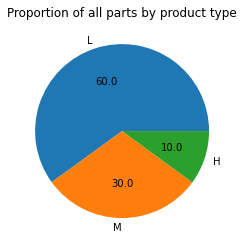

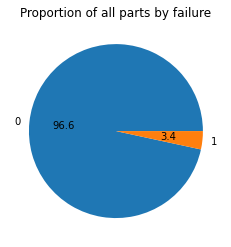

In [25]:
by_product_type = machine.product_type.value_counts()
pie_plot_categories(by_product_type, "Proportion of all parts by product type")

by_failure = machine.failure_any.value_counts()
pie_plot_categories(by_failure, "Proportion of all parts by failure")

#### Of all failures

Observations:
- The proportions by product type are more extreme than the machined proportions. That is, while `L` accounts for $60\%$ of the total volume, it generated approx. $70\%$ of all failures. For `H`: $10\%$ volume vs. $6\%$ failures. Possible explanation is the difference in quality - `H` stands for "high" quality part, `L` and `M` - for low and medium.

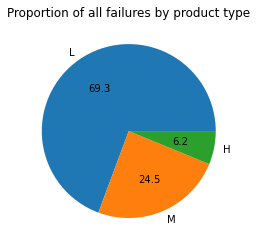

In [26]:
by_product_type = machine[machine.failure_any == 1].product_type.value_counts()
pie_plot_categories(by_product_type, "Proportion of all failures by product type")

#### Of all failures by product type

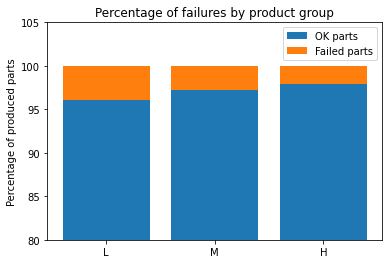

In [27]:
all_failures_by_product = machine[machine.failure_any == 1].product_type.value_counts()
total_volume_by_product = machine.product_type.value_counts()
failure_pct = 100 * all_failures_by_product / total_volume_by_product
ok_pct = 100 - failure_pct

labels = machine.product_type.value_counts().index

fig, ax = plt.subplots()

ax.bar(labels, ok_pct, label='OK parts')
ax.bar(labels, failure_pct, bottom=ok_pct, label='Failed parts')

ax.set_ylabel('Percentage of produced parts')
ax.set_title('Percentage of failures by product group')
ax.set_ylim(bottom=80)

ax.legend()
plt.show()

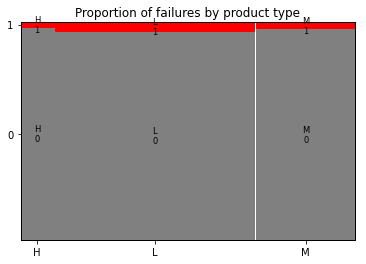

In [28]:
data = machine.groupby(["product_type", "failure_any"]).size()

props = lambda pair: {'color': 'red' if pair[1] == '1' else 'gray', }
mosaic(data=data, properties=props, title="Proportion of failures by product type")
plt.show()

#### Between failure modes

- Heat, power and over-strain account for 80% of the total failures.

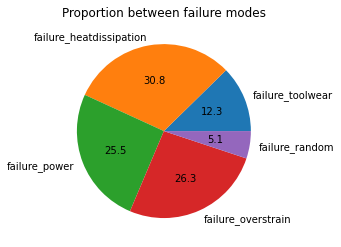

In [29]:
occurrences = {}
for failure_mode in failure_modes:
    occurrences[failure_mode] = machine[failure_mode].value_counts()[1]
occurrences = pd.Series(occurrences)

pie_plot_categories(occurrences, "Proportion between failure modes", )

#### Between failure modes by product type

Observations:
- Overall, each product has different typical failure modes.
- `failure_overstrain` proportion for `L` is much higher than the other two products.

In [30]:
all_occurrences = {}
for product_type in list("LMH"):
    occurrences = {}
    machine_by_prouduct_type = machine[machine.product_type == product_type]
    for failure_mode in failure_modes:
        occurrences[failure_mode] = machine_by_prouduct_type[failure_mode].value_counts()[1]
    
    occurrences = pd.Series(occurrences)
    occurrences_relative = occurrences / occurrences.sum()
    all_occurrences[product_type] = occurrences_relative

all_occurrences = pd.DataFrame(all_occurrences).T
all_occurrences

,failure_toolwear,failure_heatdissipation,failure_power,failure_overstrain,failure_random
L,0.096154,0.292308,0.226923,0.334615,0.050000
M,0.160920,0.356322,0.356322,0.103448,0.022989
H,0.269231,0.307692,0.192308,0.076923,0.153846


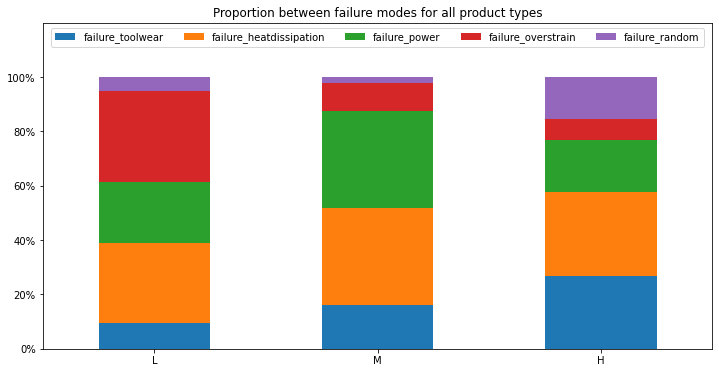

In [31]:
all_occurrences.plot.bar(stacked=True, figsize = (12, 6))

plt.ylim(top = 1.2)
plt.yticks(np.arange(0, 1.1, 0.2))
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

plt.xticks(rotation=0)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol = 5)

plt.title("Proportion between failure modes for all product types")
plt.show()

### Time series

#### Individual
Clues:
- The air and process temperatures increase at approx. 200th hour. Failures caused buy head dissipation are concentrated at the same period.
- The random failures are in two period

In [32]:
hours = machine.elapsed_time.astype('timedelta64[h]')

def plot_individual_timeseries(variable):
    plt.plot(hours, machine[variable])
    plt.xlabel("Machining time [houts]")
    plt.ylabel(variable)
    plt.title(f"Individual timeseries for {variable}")
    plt.show()

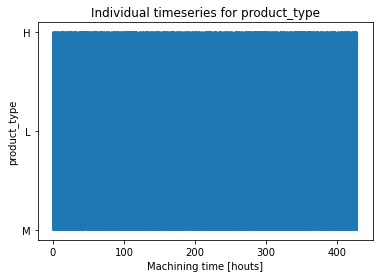

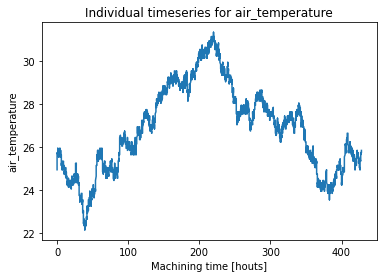

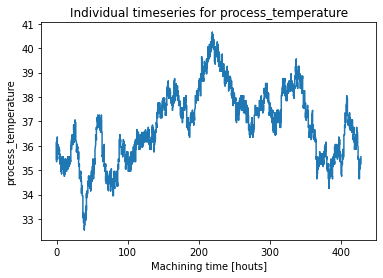

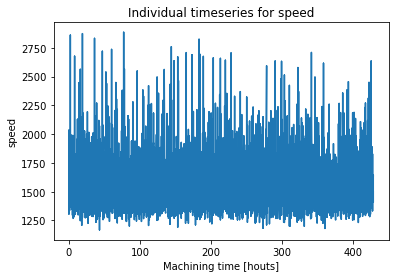

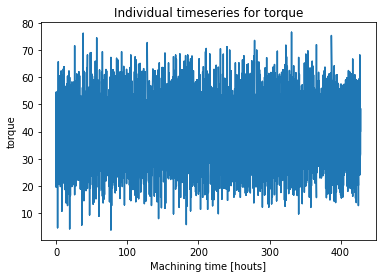

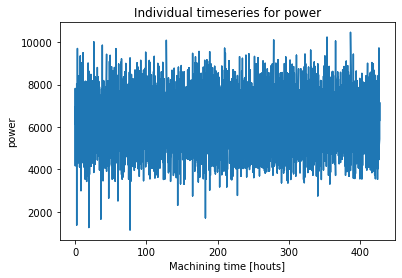

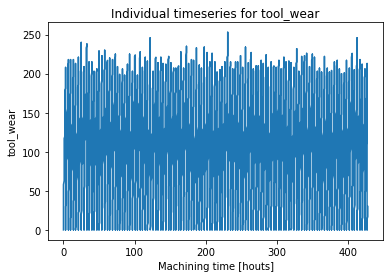

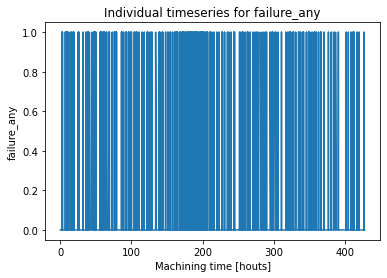

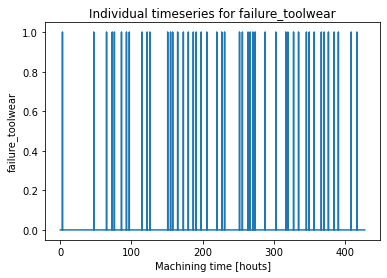

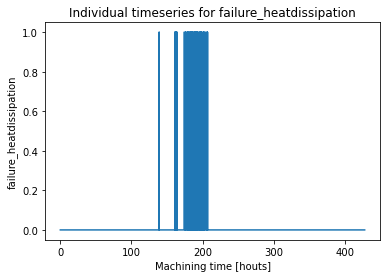

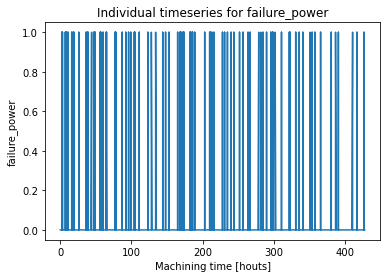

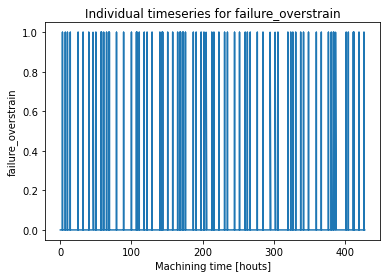

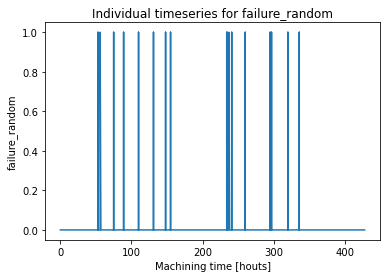

In [33]:
for variable in variables_for_time_series:
    plot_individual_timeseries(variable)

#### Multiple

Observations:
- The two temperatures correlate well.

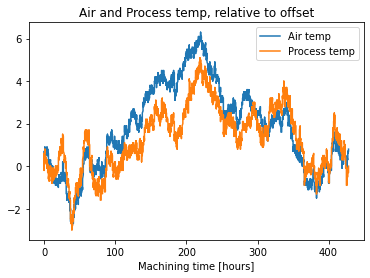

In [34]:
plt.plot(hours, machine.air_temperature - machine.air_temperature[1], label = "Air temp")
plt.plot(hours, machine.process_temperature - machine.process_temperature[1], label = "Process temp")
plt.title("Air and Process temp, relative to offset")
plt.xlabel("Machining time [hours]")
plt.legend()
plt.show()

In [35]:
# Correlations
pearson = machine[["air_temperature", "process_temperature"]].corr(method="pearson").iloc[0, 1]
spearman = machine[["air_temperature", "process_temperature"]].corr(method="spearman").iloc[0, 1]
pearson, spearman

(0.8761071581166568, 0.8642172381038954)

#### Tool replacements

Clues:
- Tool is replaced at roughly regular intervals, approx. 3.5 hours.
- No apparent relationship between failure occurrence and tool replacement.

In [36]:
all_failures = machine[machine.failure_any == 1].failure_any

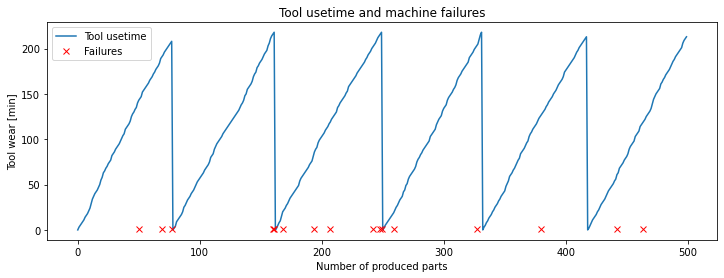

In [37]:
plt.figure(figsize=(12, 4))

plt.plot(machine.tool_wear[:500], label="Tool usetime")
plt.plot(all_failures[all_failures.index < 500], 'rx', label="Failures")

plt.xlabel("Number of produced parts")
plt.ylabel("Tool wear [min]")
plt.title("Tool usetime and machine failures")
plt.legend()
plt.show()

### Distributions
#### Histogram

Clues:
 - The two temperatures do not seem to be normally distributed.
 - `Torque` and `Speed `seem normally distributed.
 - `Speed` distibution is asymmetric with positive skew of ~2.

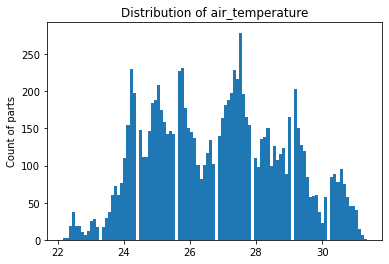

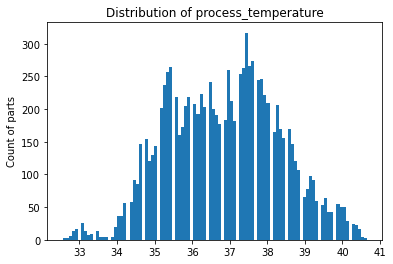

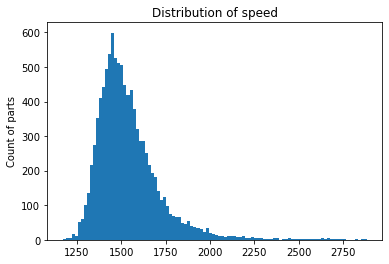

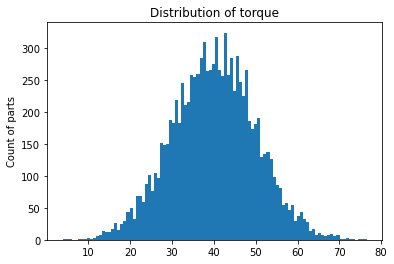

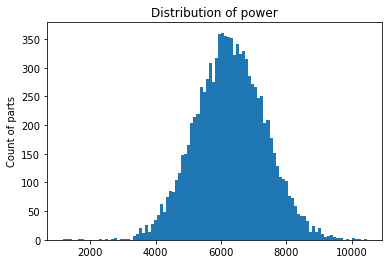

In [38]:
def plot_single_variable_distribution(var, title):
    plt.hist(machine[var], bins=100)
    plt.ylabel("Count of parts")
    plt.title(title)
    plt.show()

titles = [f"Distribution of {x}" for x in continuous_variables]

for variable, title in zip(continuous_variables, titles):
    plot_single_variable_distribution(variable, title)

In [39]:
# Skew
machine[continuous_variables].skew()


air_temperature        0.114274
process_temperature    0.015027
speed                  1.993171
torque                -0.009517
power                  0.008257
dtype: float64

#### Boxplot

Data is normalized to be plotted on one plot.

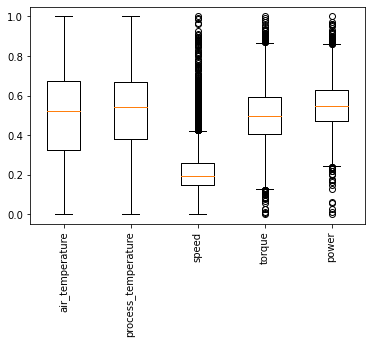

In [40]:
scaler = MinMaxScaler()
machine_continuous_variables_scaled = scaler.fit_transform(machine[continuous_variables])

plt.boxplot(machine_continuous_variables_scaled, labels=continuous_variables)
plt.xticks(rotation=90)
plt.show()

#### By product type

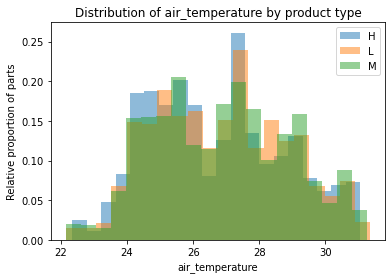

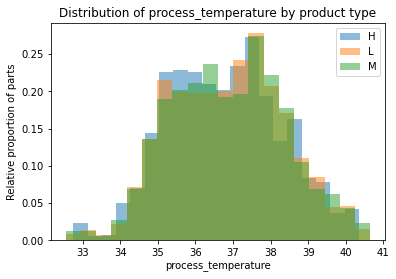

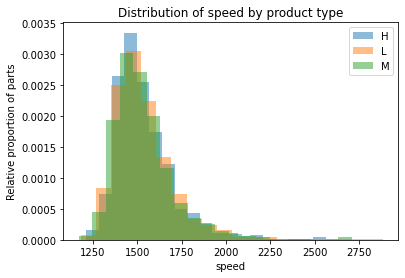

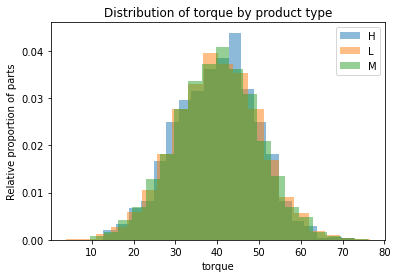

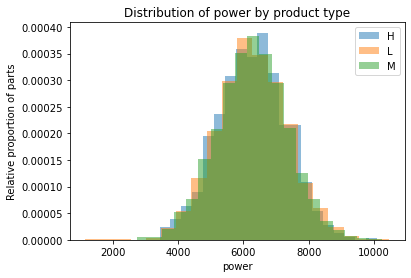

In [41]:
for variable in continuous_variables:
    for product_type, group_data in machine[[str(variable), "product_type"]].groupby("product_type"):
        data = group_data[variable]
        plt.hist(data, label=product_type, alpha=0.5, bins=20, density=True)
    plt.xlabel(variable)
    plt.ylabel("Relative proportion of parts")
    plt.title(f"Distribution of {variable} by product type")
    plt.legend()
    plt.show()

### Correlations

Clues:
 - Strong correlations between:
 any 2 out of `speed`, `power` and `torque`; `process_temp`-`air_temp`.
 - All the above make physical sense.
 - No other correlations.

In [42]:
machine_for_correlation = machine[variables_for_correlation]

pear_corr = machine_for_correlation.corr()
pear_corr_triangular = pear_corr.where(np.tril(np.ones(pear_corr.shape)).astype("bool"))

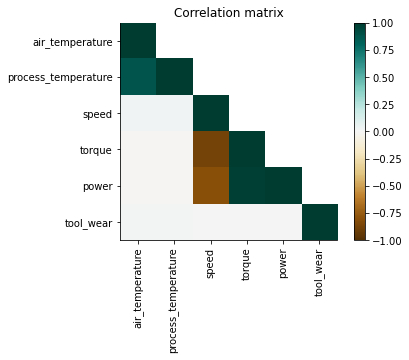

In [43]:
plt.imshow(pear_corr_triangular, cmap='BrBG', vmin=-1, vmax=1)
plt.colorbar()

ticks = np.arange(len(pear_corr_triangular))
labels = pear_corr_triangular.columns
plt.yticks(ticks, labels)
plt.xticks(ticks, labels, rotation='vertical')

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title("Correlation matrix")
plt.show()

## 3. Test hypotheses

1. Parameter of interest: $\mu_L$, $\mu_M$, $\mu_H$ - the population means of the power for each product type
2. Null hypothesis: $H_0: \mu_L = \mu_M = \mu_H$
3. Alternative hypothesis: the means are different
4. Test statistic: F statistic
5. Reject $H_0$ if: Reject $H_0$ if the p-value is less then 0.05.
6. Computations: 
7. Conclusions:
8. Practical interpretation:

In [44]:
power_by_product_type = machine.groupby("product_type").power

power_L = power_by_product_type.get_group("L")
power_M = power_by_product_type.get_group("M")
power_H = power_by_product_type.get_group("H")

In [45]:
st.f_oneway(power_L, power_M, power_H)

F_onewayResult(statistic=0.13950270083624441, pvalue=0.8697923672178566)

## 4. Model

### First

Filter data

In [46]:
columns_for_modeling = [
    "product_type", 
    "air_temperature", 
    "process_temperature", 
    "speed", 
    "torque", 
    "tool_wear", 
    "failure_any",
]

machine_for_modeling = machine[columns_for_modeling]

Add indicator variables

In [47]:
machine_for_modeling = pd.get_dummies(machine_for_modeling, columns=["product_type"])

Divide into features and target

In [48]:
target_column = "failure_any"
machine_features = machine_for_modeling.drop(columns = target_column)
machine_target = machine_for_modeling[target_column]

Normalize the data

In [49]:
scaler = MinMaxScaler()
machine_features_scaled = scaler.fit_transform(machine_features)

Split to train and test data

In [50]:
features_train, features_test, target_train, target_test = train_test_split(
    machine_features_scaled, machine_target, train_size = 0.7, test_size = 0.3, random_state = RANDOM_STATE)
print("Train data shapes: ", features_train.shape, target_train.shape)
print("Test data shapes: ", features_test.shape, target_test.shape)


Train data shapes:  (7000, 8) (7000,)
Test data shapes:  (3000, 8) (3000,)


Fit Logistic Regression model

In [51]:
model = LogisticRegression().fit(features_train, target_train)

Score the model with test data

In [52]:
score = model.score(features_test, target_test)
print(f"Score: {score}")

Score: 0.966


Check model coefficients

In [53]:
print("Model coefficients:")
for column, coef in zip(machine_features.columns, list(*model.coef_)):
    print(f"{column}: {coef.round(2)}")

Model coefficients:
air_temperature: 3.71
process_temperature: -2.27
speed: 6.04
torque: 8.54
tool_wear: 2.18
product_type_H: -0.15
product_type_L: 0.28
product_type_M: -0.13


Predict single records and compare

In [54]:
for x in np.random.randint(0, len(target_test), 20):
    random_input = features_test[x,:].reshape(1, -1)
    random_response = target_test.iloc[x]
    expected = model.predict(random_input)[0]
    print(f"index: {x}, expected: {expected}, actual: {random_response}")

index: 2949, expected: 0, actual: 0
index: 1295, expected: 0, actual: 0
index: 2322, expected: 0, actual: 0
index: 2469, expected: 0, actual: 0
index: 1292, expected: 0, actual: 0
index: 2064, expected: 0, actual: 0
index: 1883, expected: 0, actual: 0
index: 317, expected: 0, actual: 0
index: 1176, expected: 0, actual: 0
index: 440, expected: 0, actual: 0
index: 2860, expected: 0, actual: 0
index: 1252, expected: 0, actual: 0
index: 669, expected: 0, actual: 0
index: 1470, expected: 0, actual: 0
index: 1666, expected: 0, actual: 0
index: 2978, expected: 0, actual: 0
index: 858, expected: 0, actual: 0
index: 1329, expected: 0, actual: 0
index: 1707, expected: 0, actual: 0
index: 892, expected: 0, actual: 0


### Second

Added `power`

In [55]:
columns_for_modeling = [
    "product_type", 
    "air_temperature", 
    "process_temperature", 
    "speed", 
    "torque", 
    "tool_wear", 
    "failure_any",
    "power",
]

def model_data(columns_for_modeling):
    machine_for_modeling = machine[columns_for_modeling]

    # Add indicator variables
    machine_for_modeling = pd.get_dummies(machine_for_modeling, columns=["product_type"])

    # Divide into features and target
    target_column = "failure_any"
    machine_features = machine_for_modeling.drop(columns = target_column)
    machine_target = machine_for_modeling[target_column]

    # Normalize the data
    scaler = MinMaxScaler()
    machine_features_scaled = scaler.fit_transform(machine_features)

    # Split to train and test data
    features_train, features_test, target_train, target_test = train_test_split(
        machine_features_scaled, machine_target, train_size = 0.7, test_size = 0.3, random_state = 42)
    print("Train data shapes: ", features_train.shape, target_train.shape)
    print("Test data shapes: ", features_test.shape, target_test.shape)

    # Fit Logistic Regression model
    model = LogisticRegression().fit(features_train, target_train)

    # Score the model with test data
    score = model.score(features_test, target_test)
    print(f"Score: {score}")
    
model_data(columns_for_modeling)

Train data shapes:  (7000, 9) (7000,)
Test data shapes:  (3000, 9) (3000,)
Score: 0.9693333333333334


### Third

- Added `power`
- Removed `speed` and `torque`

In [56]:
# Filter data
columns_for_modeling = [
    "product_type", 
    "air_temperature", 
    "process_temperature", 
    "tool_wear", 
    "failure_any",
    "power",
]

model_data(columns_for_modeling)

Train data shapes:  (7000, 7) (7000,)
Test data shapes:  (3000, 7) (3000,)
Score: 0.969


## PCA

The first 3 principle components account for almost 90% of the total variance. We can create new data with these 3 components and model again.

In [57]:
pca = PCA().fit(machine_features_scaled)

In [58]:
total_variance = np.sum(pca.singular_values_ ** 2)
explained_variance = np.array([(x ** 2 / total_variance) for x in pca.singular_values_])
cumulative_explained_variance = np.cumsum(explained_variance)

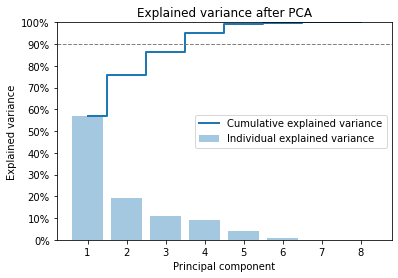

In [59]:
fig, ax = plt.subplots()

x = np.arange(1, 1 + len(explained_variance))

plot1 = ax.bar(
    x = x,
    height = explained_variance.round(2), 
    align='center', 
    label='Individual explained variance',
    alpha=0.4)

plot2 = ax.step(
    x = x, 
    y = cumulative_explained_variance,
    where='mid',
    label='Cumulative explained variance',
    linewidth = 2,
)

plt.axhline(0.9, linestyle = "--", linewidth = 1, color = "gray")
plt.ylabel('Explained variance')
plt.xlabel('Principal component')
plt.title("Explained variance after PCA")
plt.yticks(ticks = np.arange(0, 1.1, 0.1))
plt.ylim((0, 1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plt.legend()
plt.show()

### Model

In [60]:
machine_features_scaled_pca = PCA(n_components=3).fit_transform(machine_features_scaled)

X_train, X_test, y_train, y_test = train_test_split(
    machine_features_scaled_pca,
    machine_target,
    test_size = 0.3,
    train_size = 0.7,
    random_state = RANDOM_STATE)

model = LogisticRegression()

model.fit(X_train, y_train)

score = model.score(X_test, y_test)
print(f"Score: {score}")

Score: 0.965


## Reference code

In [61]:
# # Plot all columns
# [print(f'"{x}"', end=", ") for x in machine.columns]